In [8]:
%pip install statsforecast==1.4.0

  Using cached statsforecast-1.4.0-py3-none-any.whl.metadata (19 kB)
Using cached statsforecast-1.4.0-py3-none-any.whl (91 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime
import joblib

import boto3
import sagemaker
from sagemaker.model import Model
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner
from tqdm import tqdm

import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from src.train_entry import TSTrainer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [15]:
from sagemaker.serverless import ServerlessInferenceConfig

In [23]:
from src.lambda_manager import LambdaManager

In [24]:
from src.rest_api_manager import RestApiManager

In [16]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='forecast')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

In [17]:
s3 = boto3.client('s3')

raw_data_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data'

train_val_test_path = {
    'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
    'test': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test'
}
train_val_test_path, raw_data_path

({'train': 's3://elo-ml-sagemaker/forecast-project/input-data/train',
  'test': 's3://elo-ml-sagemaker/forecast-project/input-data/test'},
 's3://elo-ml-sagemaker/forecast-project/raw-data')

In [18]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
ecr_boto3 = boto3.client('ecr')
lambda_boto3 = boto3.client('lambda')
iam_boto3 = boto3.resource('iam')
apigateway_boto3 = boto3.client('apigateway')
role = sagemaker.get_execution_role()

In [5]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh preprocess-latest preprocess {config['ecr_repository']}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                                         
[+] Building 0.1s (2/3)                                                         
 => [internal] load build definition from preprocess.Dockerfile            0.0s
 => => transferring dockerfile: 627B                                       0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/library/python:3.10.12-slim-bu  0.1s
[+] Building 0.3s (7/8)                                                         
 => [internal] load build definition from preprocess.Dockerfile            0.0s
 => => transferring dockerfile: 627

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if 'imageTag' in ecr_meta_data_dict and ecr_meta_data_dict['imageTag'].startswith('preprocess'):
        preprocess_image_tag = ecr_meta_data_dict['imageTag']

preprocess_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{preprocess_image_tag}'

In [7]:
print("Test Processing Job Locally")

Test Processing Job Locally


In [8]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

In [9]:
test_processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type='local',
    instance_count=config['preprocess_instance_count'],
    base_job_name=config['preprocess_base_job_name'],
    entrypoint=['python3', 'preprocess_entry.py']
)

test_processor.run(
    # The data sets are loaded from the source S3 path to the destination path in the processing container
    inputs=[ProcessingInput(
        source=raw_data_path,
        destination=config['preprocess_input']
    )],
    outputs=[
        ProcessingOutput(
            # The processing script writes train and test splits to these locations in the container
            source=os.path.join(config['preprocess_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ],
    # Run in test mode to not upload the preprocessed data to S3
    arguments=['--test_mode']
)

INFO:sagemaker:Creating processing-job with name processing-job-2024-06-16-23-23-50-754
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-spuig:
    container_name: lm5utp46yk-algo-1-spuig
    entrypoint:
    - python3
    - preprocess_entry.py
    - --test_mode
    environment: []
    image: 616052791267.dkr.ecr.us-east-2.amazonaws.com/ml-sagemaker:preprocess-latest
    networks:
      sagemaker-local:
        aliases:
        - algo-1-spuig
    stdin_open: true
 

 Container lm5utp46yk-algo-1-spuig  Creating
 Container lm5utp46yk-algo-1-spuig  Created
Attaching to lm5utp46yk-algo-1-spuig
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,373 INFO __main__: Loading raw data...
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,380 INFO __main__: Splitting data into train and test sets...
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,383 INFO __main__: Train set period: 2013-01-04 to 2023-12-08
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,383 INFO __main__: Test set period: 2023-12-15 to 2024-06-07
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,384 INFO __main__: Forecasting Covid-19 data...
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,385 INFO __main__: Running in test mode...
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,386 INFO __main__: Covid Train set period: 2018-04-13 to 2020-03-06
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,386 INFO __main__: Covid Test set period: 2020-03-13 to 2020-05-15
lm5utp46yk-algo-1-spuig  | 2024-06-16 23:23:53,3

INFO:sagemaker.local.image:===== Job Complete =====


lm5utp46yk-algo-1-spuig exited with code 0
Aborting on container exit...
 Container lm5utp46yk-algo-1-spuig  Stopping
 Container lm5utp46yk-algo-1-spuig  Stopped


In [10]:
print('run in the cloud')

run in the cloud


In [11]:
processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type=config['preprocess_instance_type'],
    instance_count=config['preprocess_instance_count'],
    base_job_name=config['preprocess_base_job_name'],
    sagemaker_session=sagemaker_session,
    entrypoint=['python3', 'preprocess_entry.py']
)

processor.run(
    # The data sets are loaded from the source S3 path to the destination path in the processing container
    inputs=[ProcessingInput(
        source=raw_data_path,
        destination=config['preprocess_input']
    )],
    outputs=[
        ProcessingOutput(
            # The processing script writes train and test splits to these locations in the container
            source=os.path.join(config['preprocess_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ]
)

INFO:sagemaker:Creating processing-job with name processing-job-2024-06-16-23-25-21-920


............................................................
2024-06-16 23:35:23,460 INFO __main__: Loading raw data...
2024-06-16 23:35:23,472 INFO __main__: Splitting data into train and test sets...
2024-06-16 23:35:23,475 INFO __main__: Train set period: 2013-01-04 to 2023-12-08
2024-06-16 23:35:23,475 INFO __main__: Test set period: 2023-12-15 to 2024-06-07
2024-06-16 23:35:23,475 INFO __main__: Forecasting Covid-19 data...
2024-06-16 23:35:23,477 INFO __main__: Covid Train set period: 2013-01-04 to 2020-03-06
2024-06-16 23:35:23,477 INFO __main__: Covid Test set period: 2020-03-13 to 2023-09-29
2024-06-16 23:35:23,477 INFO __main__: Covid-19 Train set size: 375
2024-06-16 23:35:23,477 INFO __main__: Covid-19 Test set size: 186
2024-06-16 23:35:24,378 INFO __main__: Saving data...
2024-06-16 23:35:24,412 INFO __main__: Saved train data to /opt/ml/processing/output/train/train.csv
2024-06-16 23:35:24,414 INFO __main__: Saved test data to /opt/ml/processing/output/test/test.csv
2024

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


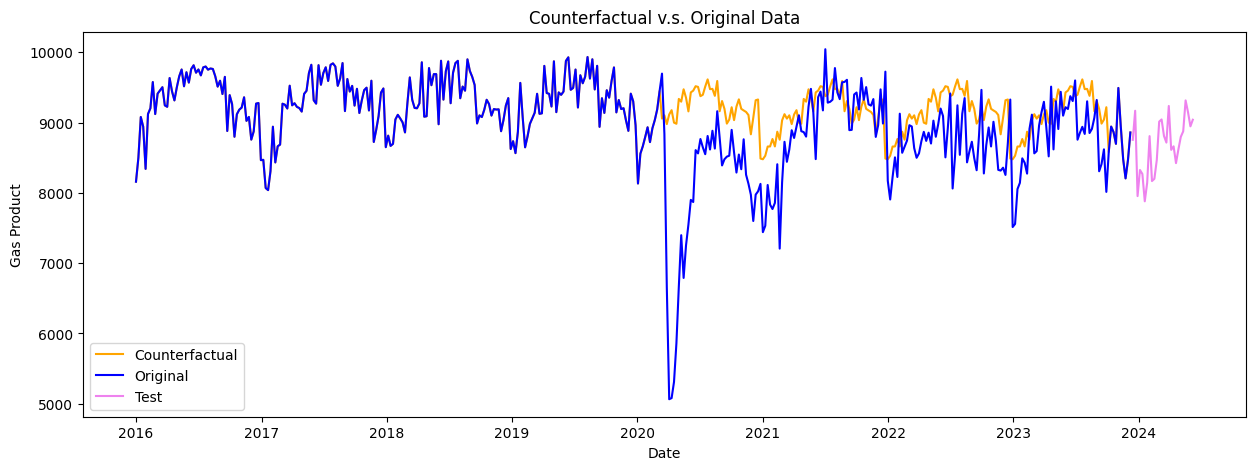

In [11]:
train = pd.read_csv(os.path.join(train_val_test_path['train'], 'train.csv'), index_col=0)
train.index = pd.to_datetime(train.index)
train.index.freq = config['freq']
test = pd.read_csv(os.path.join(train_val_test_path['test'], 'test.csv'), index_col=0)
test.index = pd.to_datetime(test.index)
test.index.freq = config['freq']

fig, ax = plt.subplots(figsize=(15, 5))
# Plot original data
ax.plot(train.loc ['2016':'2023']['gas_product_forecast'], label='Counterfactual', color='orange')
ax.plot(train.loc['2016':'2023']['gas_product'], label='Original', color='blue')
ax.plot(test['gas_product'], label='Test', color='violet')
ax.set_xlabel('Date')
ax.set_ylabel('Gas Product')
ax.set_title('Counterfactual v.s. Original Data')
plt.legend(loc='best')
plt.show()

In [13]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh train-latest train {config['ecr_repository']}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                                         
[+] Building 0.2s (2/3)                                                         
 => [internal] load build definition from train.Dockerfile                 0.0s
 => => transferring dockerfile: 1.19kB                                     0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/library/python:3.10.12-slim-bu  0.1s
[+] Building 0.3s (3/3)                                                         
 => [internal] load build definition from train.Dockerfile                 0.0s
 => => transferring dockerfile: 1.1

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if 'imageTag' in ecr_meta_data_dict and ecr_meta_data_dict['imageTag'].startswith('train'):
        train_image_tag = ecr_meta_data_dict['imageTag']

train_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{train_image_tag}'

train_image_uri

'616052791267.dkr.ecr.us-east-2.amazonaws.com/ml-sagemaker:train-latest'

In [16]:
print('Test Training Job Locally')

Test Training Job Locally


In [17]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

In [18]:
# Use fixed hyperparameters for testing
test_hyperparameters = {
    'test_mode': 1,
    'use_counterfactual_data': 1,
    'preprocess_detrend': 1,
    'preprocess_deseasonalize': 1,
    'preprocess_fourier_k': 2
}

test_estimator = Estimator(
    image_uri=train_image_uri,
    role=role,
    instance_count=config['train_instance_count'],
    instance_type='local',
    volume_size=config['volume_size'],
    output_path=config['output_path'],
    base_job_name=config['train_base_job_name'],
    hyperparameters=test_hyperparameters,
    code_location=config['code_location']
)

test_estimator.fit(train_val_test_path)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating training-job with name: training-job-2024-06-16-23-57-01-772
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-z6ff5:
    command: train
    container_name: 35u86xzv1z-algo-1-z6ff5
    environment:
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    image: 616052791267.dkr.ecr.us-east-2.amazonaws.com/ml-sagemaker:train-latest
    networks:
      s

 Container 35u86xzv1z-algo-1-z6ff5  Creating
 Container 35u86xzv1z-algo-1-z6ff5  Created
Attaching to 35u86xzv1z-algo-1-z6ff5
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03,795 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03,796 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03,815 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03,834 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03,836 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03,855 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
35u86xzv1z-algo-1-z6ff5  | 2024-06-16 23:57:03

INFO:root:creating /tmp/tmp0cmctj8o/artifacts/output/data
INFO:root:copying /tmp/tmp0cmctj8o/algo-1-z6ff5/output/success -> /tmp/tmp0cmctj8o/artifacts/output
INFO:root:copying /tmp/tmp0cmctj8o/model/model_train_target_pipeline.joblib -> /tmp/tmp0cmctj8o/artifacts/model
INFO:root:copying /tmp/tmp0cmctj8o/model/model_train_fourier_transformer.joblib -> /tmp/tmp0cmctj8o/artifacts/model
INFO:root:copying /tmp/tmp0cmctj8o/model/model_train_data.csv -> /tmp/tmp0cmctj8o/artifacts/model
INFO:root:copying /tmp/tmp0cmctj8o/model/model_full_target_pipeline.joblib -> /tmp/tmp0cmctj8o/artifacts/model
INFO:root:copying /tmp/tmp0cmctj8o/model/model_full_fourier_transformer.joblib -> /tmp/tmp0cmctj8o/artifacts/model
INFO:root:copying /tmp/tmp0cmctj8o/model/model_full_data.csv -> /tmp/tmp0cmctj8o/artifacts/model


35u86xzv1z-algo-1-z6ff5 exited with code 0
Aborting on container exit...
 Container 35u86xzv1z-algo-1-z6ff5  Stopping
 Container 35u86xzv1z-algo-1-z6ff5  Stopped


INFO:sagemaker.local.image:===== Job Complete =====


In [19]:
print('Hyperparameter Tuning')

Hyperparameter Tuning


In [20]:
search_space = {
    'use_counterfactual_data': CategoricalParameter([1, 0]),
    'preprocess_detrend': CategoricalParameter([1, 0]),
    'preprocess_deseasonalize': CategoricalParameter([1, 0]),
    'preprocess_fourier_k': IntegerParameter(min_value=1, max_value=config['max_k'])
}

In [21]:
metric_definitions = [
    {
        'Name': config['objective_metric_name'],
        # Regex for matching the logs outputted by the training script
        'Regex': 'Mean MSE across all splits: ([0-9\\.]+)',
    }
]

In [22]:
estimator = Estimator(
    image_uri=train_image_uri,
    role=role,
    instance_count=config['train_instance_count'],
    instance_type=config['train_instance_type'],
    volume_size=config['volume_size'],
    max_run=config['max_run'],
    output_path=config['output_path'],
    base_job_name=config['train_base_job_name'],
    hyperparameters={
        'test_mode': 0
    },
    code_location=config['code_location'],
    use_spot_instances=config['use_spot_instances'],
    max_wait=config['max_wait'],
    checkpoint_s3_uri=config['checkpoint_s3_uri'],
    max_retry_attempts=config['max_retry_attempts']
)

In [23]:
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=config['objective_metric_name'],
    hyperparameter_ranges=search_space,
    metric_definitions=metric_definitions,
    strategy=config['strategy'],
    objective_type=config['objective_type'],
    max_jobs=config['max_jobs'],
    max_parallel_jobs=config['max_parallel_jobs'],
    base_tuning_job_name=config['base_tuning_job_name']
)

In [24]:
tuner.fit(train_val_test_path)

INFO:sagemaker:Creating hyperparameter tuning job with name: tuning-job-240617-0000


...........................................................................................................................................................................................!


In [25]:
hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name)

hpo_results = hpo_analytics.dataframe()

hpo_results.sort_values('FinalObjectiveValue', ascending=True)

,preprocess_deseasonalize,preprocess_detrend,preprocess_fourier_k,use_counterfactual_data,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
16,1.0,1.0,8.0,1.0,tuning-job-240617-0000-004-9516f5ed,Completed,5157.772461,2024-06-17 00:01:36+00:00,2024-06-17 00:08:20+00:00,404.0
3,1.0,1.0,9.0,1.0,tuning-job-240617-0000-017-980d3a37,Completed,5167.840820,2024-06-17 00:09:09+00:00,2024-06-17 00:15:48+00:00,399.0
6,1.0,1.0,10.0,1.0,tuning-job-240617-0000-014-0e64c1da,Completed,5411.009766,2024-06-17 00:07:19+00:00,2024-06-17 00:14:04+00:00,405.0
1,1.0,1.0,7.0,1.0,tuning-job-240617-0000-019-3edf808a,Completed,6000.463379,2024-06-17 00:09:20+00:00,2024-06-17 00:15:00+00:00,340.0
18,1.0,1.0,5.0,1.0,tuning-job-240617-0000-002-6d616f4a,Completed,6082.669922,2024-06-17 00:01:32+00:00,2024-06-17 00:06:17+00:00,285.0
0,1.0,1.0,6.0,1.0,tuning-job-240617-0000-020-2226db96,Completed,6209.287598,2024-06-17 00:09:38+00:00,2024-06-17 00:14:32+00:00,294.0
9,1.0,0.0,2.0,1.0,tuning-job-240617-0000-011-e171c1e4,Completed,6462.827148,2024-06-17 00:05:49+00:00,2024-06-17 00:09:02+00:00,193.0
5,0.0,1.0,10.0,1.0,tuning-job-240617-0000-015-cb8183dd,Completed,18376.416016,2024-06-17 00:07:29+00:00,2024-06-17 00:14:14+00:00,405.0
2,0.0,1.0,9.0,1.0,tuning-job-240617-0000-018-930ac2ac,Completed,20128.765625,2024-06-17 00:09:10+00:00,2024-06-17 00:15:49+00:00,399.0
10,0.0,0.0,8.0,1.0,tuning-job-240617-0000-010-9db0018b,Completed,20391.736328,2024-06-17 00:01:44+00:00,2024-06-17 00:08:23+00:00,399.0


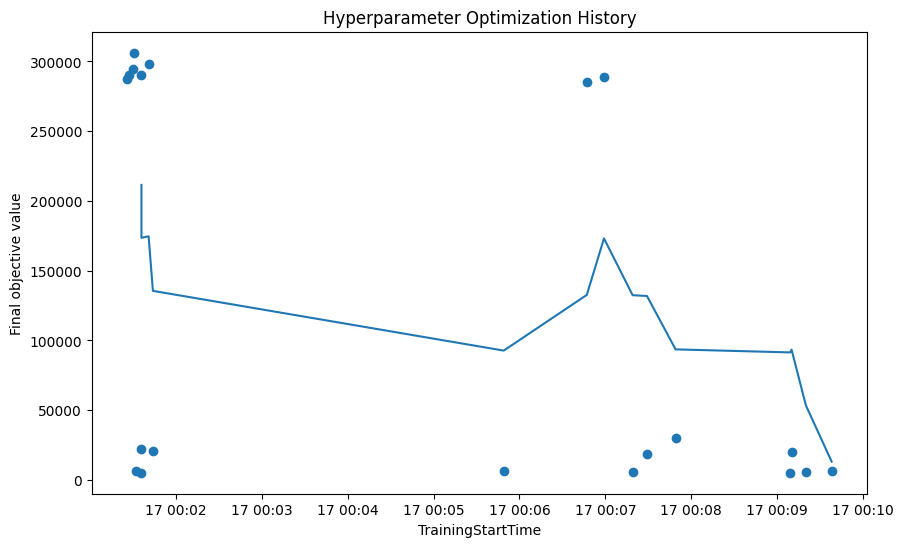

In [26]:
plt.figure(figsize=(10, 6))
# Sort by TrainingStartTime
hpo_results.sort_values('TrainingStartTime', inplace=True)
plt.scatter(hpo_results['TrainingStartTime'], hpo_results['FinalObjectiveValue'])
plt.plot(hpo_results['TrainingStartTime'], hpo_results['FinalObjectiveValue'].rolling(7).mean())
plt.xlabel('TrainingStartTime')
plt.ylabel('Final objective value')
plt.title('Hyperparameter Optimization History')
plt.show();

In [27]:
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)['BestTrainingJob']['TrainingJobName']

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=best_model_name
)['ModelArtifacts']['S3ModelArtifacts']

print(f'Best model artifacts persisted at {best_model_s3_path}')

Best model artifacts persisted at s3://elo-ml-sagemaker/forecast-project/models/tuning-job-240617-0000-004-9516f5ed/output/model.tar.gz


In [28]:
!aws s3 cp {best_model_s3_path} /tmp/model_artifacts.tar.gz
# The options -x = extract files from the archive, -z = uncompress the archive with gzip, -f = use archive file, and -C = change directory to the specified directory
!tar -xzf /tmp/model_artifacts.tar.gz -C /tmp

download: s3://elo-ml-sagemaker/forecast-project/models/tuning-job-240617-0000-004-9516f5ed/output/model.tar.gz to ../../../../../tmp/model_artifacts.tar.gz
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


In [12]:
model_full = joblib.load('/tmp/model_full_target_pipeline.joblib')
fourier_transformer_full = joblib.load('/tmp/model_full_fourier_transformer.joblib')

model_train = joblib.load('/tmp/model_train_target_pipeline.joblib')
fourier_transformer_train = joblib.load('/tmp/model_train_fourier_transformer.joblib')

In [13]:
y_train = train['gas_product_forecast'].copy()
y_train.index = pd.PeriodIndex(y_train.index, freq=config['freq'])

y_test = test['gas_product'].copy()
y_test.index = pd.PeriodIndex(y_test.index, freq=config['freq'])

y_full = pd.concat([y_train, y_test], axis=0)

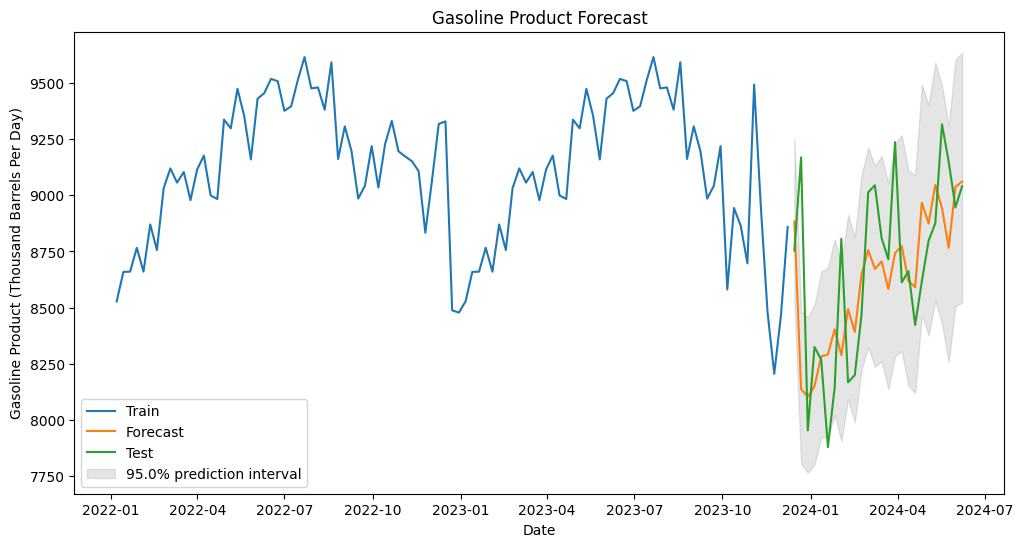

In [14]:
TSTrainer.plot_forecast(
    target_pipeline=model_train,
    fourier_transformer=fourier_transformer_train,
    y_train=y_train,
    y_test=y_test,
    conf=config['conf'],
    forecast_horizon=config['forecast_horizon'],
    start_date='2022-01-01'
)

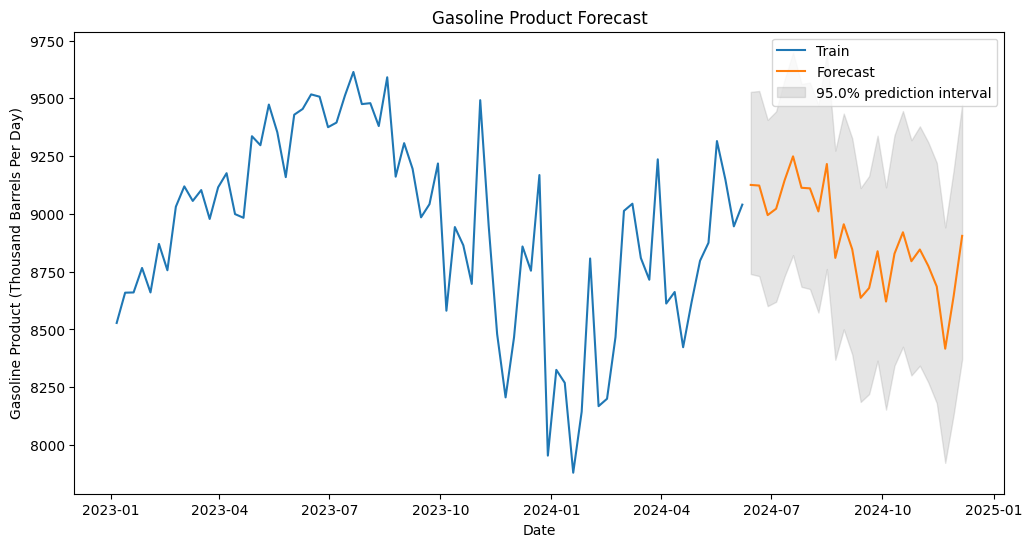

In [15]:
TSTrainer.plot_forecast(
    target_pipeline=model_full,
    fourier_transformer=fourier_transformer_full,
    y_train=y_full,
    y_test=None,
    conf=config['conf'],
    forecast_horizon=config['forecast_horizon'],
    start_date='2023-01-01'
)

In [16]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh serve-latest serve {config['ecr_repository']}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                                         
[+] Building 0.2s (2/3)                                                         
 => [internal] load build definition from serve.Dockerfile                 0.0s
 => => transferring dockerfile: 679B                                       0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/library/python:3.10.12-slim-bu  0.1s
[+] Building 0.3s (3/3)                                                         
 => [internal] load build definition from serve.Dockerfile                 0.0s
 => => transferring dockerfile: 679

KeyError: 'imageTag'

In [17]:
# Construct serving image uri
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if 'imageTag' in ecr_meta_data_dict and ecr_meta_data_dict['imageTag'].startswith('serve'):
        serve_image_tag = ecr_meta_data_dict['imageTag']

serve_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{serve_image_tag}'

In [19]:
best_model_s3_path = 's3://elo-ml-sagemaker/forecast-project/models/tuning-job-240617-0000-004-9516f5ed/output/model.tar.gz'

In [20]:
best_model = Model(
    image_uri=serve_image_uri,
    model_data=best_model_s3_path,
    role=role,
    name=config['serve_model_name'],
    code_location=config['code_location'],
    sagemaker_session=sagemaker_session
)

In [23]:
serverless_inference_config = ServerlessInferenceConfig(
    memory_size_in_mb=config['serve_memory_size_in_mb'],
    max_concurrency=config['serve_max_concurrency']
)

In [24]:
best_model.deploy(
    initial_instance_count=config['serve_initial_instance_count'],
    instance_type=config['serve_instance_type'],
    endpoint_name=config['serve_endpoint_name'],
    serverless_inference_config=serverless_inference_config,
    volume_size=config['serve_volume_size'],
    wait=True # Wait until the deployment finishes
)

----------------!

In [19]:
lambda_manager = LambdaManager(
    lambda_client=lambda_boto3,
    iam_resource=iam_boto3
)

# Use the execution role we created for the lambda function
lambda_execution_role, exist = lambda_manager.create_iam_role_for_lambda(
    iam_role_name=config['lambda_execution_role_name']
)

2024-06-17 13:41:12,074 INFO src.lambda_manager: Found IAM role forecast-lambda-execution-role


In [20]:
deployment_package = lambda_manager.create_deployment_package(
    source_file=os.path.join(config['src_dir_path'], config['lambda_source_file']),
    destination_file=config['lambda_source_file']
)

type(deployment_package)

bytes

In [21]:
lambda_function_arn = lambda_manager.create_function(
    function_name=config['lambda_function_name'],
    function_description=config['lambda_function_description'],
    time_out=config['lambda_time_out'],
    python_runtime=config['lambda_python_runtime'],
    iam_role=lambda_execution_role,
    handler_name=config['lambda_handler_name'],
    deployment_package=deployment_package,
    publish=config['lambda_publish'],
    # The configuration structures the env_vars as a list of dicts, but the SDK expects a single dict of key-value pairs
    env_vars={env_key: env_value for dict_obj in config['lambda_env_vars']
                                 for env_key, env_value in dict_obj.items()}
)

2024-06-17 13:41:35,991 INFO src.lambda_manager: Function forecast-lambda is active with ARN arn:aws:lambda:us-east-2:616052791267:function:forecast-lambda


In [22]:
response = lambda_manager.invoke_function(
    function_name=config['lambda_function_name'],
    payload={'body': json.dumps({'periods': '10', 'conf': '0.90'})},
    include_log=False
)

response_payload = json.loads(response['Payload'].read().decode('utf-8'))
predictions = json.loads(response_payload['body'])

pd.DataFrame.from_dict(predictions)

2024-06-17 13:42:06,713 INFO src.lambda_manager: Invoked function forecast-lambda


,date,lower_pi_0.9,predictions,upper_pi_0.9
0,2024-06-07,8792.908315,9117.347695,9453.758189
1,2024-06-14,8800.491613,9125.210800,9461.911426
2,2024-06-21,8792.684031,9122.503513,9464.694745
3,2024-06-28,8662.987762,8994.696484,9339.106444
4,2024-07-05,8683.187743,9022.263524,9374.580109
5,2024-07-12,8794.954750,9144.954593,9508.882863
6,2024-07-19,8888.657163,9248.900292,9623.743502
7,2024-07-26,8751.864121,9112.869959,9488.766935
8,2024-08-02,8743.526071,9110.386818,9492.640304
9,2024-08-09,8641.973591,9010.604497,9394.959676


In [25]:
rest_api_manager = RestApiManager(
    api_name=config['api_gateway_api_name'],
    api_base_path=config['api_gateway_api_base_path'],
    api_stage=config['api_gateway_api_stage'], # Development stage
    lambda_function_name=config['lambda_function_name']
)

rest_api_manager.setup_rest_api(
    apiKeyRequired=config['api_gateway_api_key_required'],
    api_key_name=config['api_gateway_api_key_name'],
    enabled=config['api_gateway_enabled'],
    usage_plan_name=config['api_gateway_usage_plan_name']
)

2024-06-17 13:48:28,355 INFO src.rest_api_manager: Created REST API forecast-api with ID pqjrjjz1vk
2024-06-17 13:48:28,405 INFO src.rest_api_manager: Found root resource of the REST API with ID fy1ch4clri
2024-06-17 13:48:28,465 INFO src.rest_api_manager: Created resource forecast under root resource with ID 0wv27e
2024-06-17 13:48:28,522 INFO src.rest_api_manager: Created POST method for resource 0wv27e
2024-06-17 13:48:28,584 INFO src.rest_api_manager: Set up Lambda integration for POST method on resource 0wv27e
2024-06-17 13:48:28,925 INFO src.rest_api_manager: Deployed REST API pqjrjjz1vk
2024-06-17 13:48:28,992 INFO src.rest_api_manager: Granted permission to let Amazon API Gateway invoke function arn:aws:lambda:us-east-2:616052791267:function:forecast-lambda from arn:aws:execute-api:us-east-2:616052791267:pqjrjjz1vk/*/POST/forecast
2024-06-17 13:48:29,045 INFO src.rest_api_manager: Created API key with ID ukkvq4bh7c
2024-06-17 13:48:29,392 INFO src.rest_api_manager: Created usag

In [ ]:
payload = {'periods': '5', 'conf': '0.80'}

predictions = rest_api_manager.invoke_rest_api(
    payload=payload
)

pd.DataFrame.from_dict(predictions)

2024-06-17 13:49:11,092 INFO src.rest_api_manager: Constructed REST API base URL: https://pqjrjjz1vk.execute-api.us-east-2.amazonaws.com/dev/forecast
